In [1]:
import os
import pandas as pd
import numpy as np
import scipy.interpolate as interp
from scipy.optimize import curve_fit as lsq
from sklearn.metrics import r2_score as rsquared
import BrukerMRI as bruker
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = [10,8]

In [2]:
def lorentzian(offset,*args):
    param = []
    for arg in args:
        param.append(arg)
    param=np.array(param).squeeze()
    offset=offset.squeeze()
    pools = round(param.shape[0]/3)
    L = np.zeros((pools,round(offset.shape[0])));
    
    for n in range(0,pools):
        P=param[n::pools]
        fwhh=P[1]**2/4
        L[n,:]=  (P[0]*fwhh) /   (  fwhh + np.square(offset-P[2])   )
    
    return np.sum(L,axis=0)

In [3]:
image_path = "..\..\Data\Images"
average_path = "..\..\Data\Averages"
save_path = "..\..\Data\csv"
here = os.getcwd()
os.chdir(image_path)
concs = pd.read_csv('concs.csv', header = None).values.squeeze()
masks = pd.read_csv('mask.csv', header = None).values.squeeze()
masks = masks.reshape((128,8,128))
conc_masks = pd.read_csv('conc_mask.csv', header = None).values.squeeze()
conc_masks = conc_masks.reshape((128,8,128))
method = pd.read_csv('cest_fit_info.csv', header = None).values.squeeze()
ppmfull = pd.read_csv('ppm.txt',header = None).values.squeeze()

In [4]:
pH_folders = [s for s in os.listdir() if "pH" in s]

In [5]:
pHs = np.zeros((len(pH_folders),1))

In [6]:
for p in range(0,len(pH_folders)):
    mainDir = './'+pH_folders[p]+'/'
    expNum = 1 # 1 = CEST, 2 = T2, 3 = T1 if available
    expObj = bruker.ReadExperiment(mainDir, expNum)
    cest_img = np.flipud(expObj.proc_data)
    mask = masks[:,p,:].squeeze()
    conc_mask = conc_masks[:,p,:].squeeze()
    pHs[p] = float(pH_folders[p][2::])
    
    indices = np.nonzero(mask.reshape((1,-1)))[1]
    conc_mask = conc_mask.reshape((1,-1)).squeeze()
    cest_img = cest_img.reshape((-1,ppmfull.shape[0]))
    ppmexp = ppmfull[expObj.method["cest_number_of_data_points"][0]::]
    
    ## Fit PBS-only sample at this pH in order to calculate difference from baseline (if desired)
    os.chdir(here)
    os.chdir(average_path+"/PBS/CEST")
    pH_files = [s for s in os.listdir() if "pH" in s]
    d_pbs_unfit = pd.read_csv(pH_files[p], header = None).values.squeeze()
    d_pbs_unfit = d_pbs_unfit[expObj.method["cest_number_of_data_points"][0]::]
    d_pbs_ppm = pd.read_csv("ppm.txt", header = None).values.squeeze()
    d_pbs_ppm = d_pbs_ppm[expObj.method["cest_number_of_data_points"][0]::]
    d_pbs_ppm = d_pbs_ppm - d_pbs_ppm[np.argmin(d_pbs_unfit)]
    d_pbs_unfit = d_pbs_unfit/d_pbs_unfit[0]
    
    ppmlong = np.linspace(d_pbs_ppm[0],d_pbs_ppm[-1],1000).squeeze()
    f = interp.splrep(d_pbs_ppm,d_pbs_unfit,s=0)
    siglong = 1-interp.splev(ppmlong,f)
    beta , cov = lsq(lorentzian,ppmlong,siglong,p0=np.array([1,1,0]),bounds=(np.array([0.2,0.1,-0.5]),np.array([1.0,10,0.5])),ftol=1e-4,xtol=1e-4,gtol=1e-4,maxfev = 200)
    beta[int(beta.shape[0]*2/3)::] = beta[int(beta.shape[0]*2/3)::] - beta[int(beta.shape[0]*2/3)]
    d_pbs_rsq = rsquared(1-d_pbs_unfit,lorentzian(d_pbs_ppm,beta))
    d_pbs_fit = lorentzian(ppmexp,beta)
    
    os.chdir(here)
    os.chdir(image_path)
        
    
    d_centered = np.zeros((indices.shape[0],expObj.method["cest_number_of_data_points"][1]))
    d_uncentered = np.zeros((indices.shape[0],expObj.method["cest_number_of_data_points"][1]))
    d_diff = np.zeros((indices.shape[0],expObj.method["cest_number_of_data_points"][1]))
    d_ppm = np.zeros((indices.shape[0],expObj.method["cest_number_of_data_points"][1]))
    d_rsq = np.zeros((1,indices.shape[0])).squeeze()
    d_pH = np.zeros((1,indices.shape[0])).squeeze()
    d_conc = np.zeros((1,indices.shape[0])).squeeze()
    d_pars = np.zeros((indices.shape[0],method.shape[0]))
    
    for q in range(0,indices.shape[0]):
        d_pH[q] = pHs[p]
        d_conc[q] = conc_mask[indices[q]]
        
        sig = cest_img[indices[q],:].squeeze()
        sig = sig[expObj.method["cest_number_of_data_points"][0]::]
        ppmadj = ppmexp-ppmexp[np.argmin(sig)]
        #d_ppm[q,:] = ppm_adj
        sig = sig/sig[0]
        d_uncentered[q,:] = sig
        
        ppmlong = np.linspace(ppmadj[0],ppmadj[-1],1000).squeeze()
        f = interp.splrep(ppmadj,sig,s=0)
        siglong = 1-interp.splev(ppmlong,f)
        
        beta , cov = lsq(lorentzian,ppmlong,siglong,p0=method[:,1],bounds=(method[:,0],method[:,2]),ftol=1e-4,xtol=1e-4,gtol=1e-4,maxfev = 200)
        ppmadj = ppmadj - beta[int(beta.shape[0]*2/3)]
        d_ppm[q,:] = ppmadj
        ppmlong = np.linspace(ppmadj[0],ppmadj[-1],1000).squeeze()
        f = interp.splrep(ppmadj,sig,s=0)
        siglong = 1-interp.splev(ppmlong,f)
        beta , cov = lsq(lorentzian,ppmlong,siglong,p0=method[:,1],bounds=(method[:,0],method[:,2]),ftol=1e-4,xtol=1e-4,gtol=1e-4,maxfev = 200)
        beta[int(beta.shape[0]*2/3)::] = beta[int(beta.shape[0]*2/3)::] - beta[int(beta.shape[0]*2/3)]
        d_centered[q,:] = lorentzian(ppmexp,beta)
        d_rsq[q] = rsquared(1-sig,lorentzian(ppmadj,beta))
        d_pars[q,:] = beta
        d_diff[q,:] = d_centered[q,:] - d_pbs_fit
    
    if p==0:
        centered = d_centered
        uncentered = d_uncentered
        rsq = d_rsq
        ppm = d_ppm
        pH = d_pH
        conc = d_conc
        pars = d_pars
        pbs_unfit = [d_pbs_unfit]
        pbs_fit = [d_pbs_fit]
        pbs_ppm = [d_pbs_ppm]
        pbs_rsq = [d_pbs_rsq]
        diff = d_diff
        
    else:
        centered = np.concatenate((centered,d_centered))
        uncentered= np.concatenate((uncentered,d_uncentered))
        rsq = np.concatenate((rsq,d_rsq))
        ppm = np.concatenate((ppm,d_ppm))
        pH = np.concatenate((pH,d_pH))
        conc = np.concatenate((conc,d_conc))
        pars = np.concatenate((pars,d_pars))
        pbs_unfit = np.concatenate((pbs_unfit,[d_pbs_unfit]))
        pbs_fit = np.concatenate((pbs_fit,[d_pbs_fit]))
        pbs_ppm = np.concatenate((pbs_ppm,[d_pbs_ppm]))
        pbs_rsq = np.concatenate((pbs_rsq,[d_pbs_rsq]))
        diff = np.concatenate((diff,d_diff))
        

os.chdir(here)

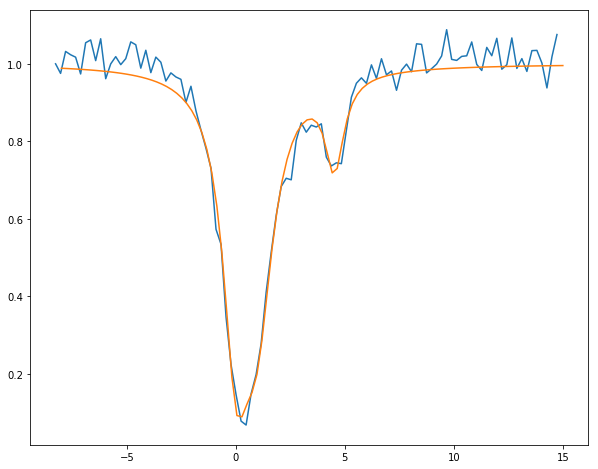

In [7]:
plt.plot(ppm[q,:],uncentered[q,:]);
plt.hold
plt.plot(ppmexp,1-centered[q,:]);

In [8]:
centered[rsq>0.90,:].shape

(12785, 101)

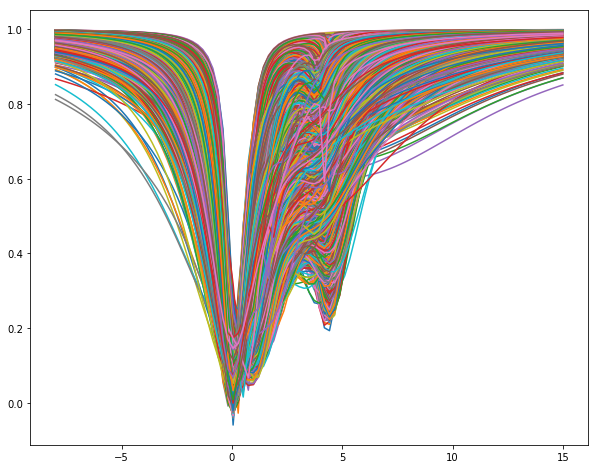

In [9]:
plt.plot(ppmexp,1-centered[rsq>0.80,:].transpose());

In [10]:
## Save csv files
os.chdir(save_path)
np.savetxt('fitted_cest.csv',centered,delimiter=',')
np.savetxt('unfitted_cest.csv',uncentered,delimiter=',')
np.savetxt('rsq.csv',rsq,delimiter=',')
np.savetxt('ppm.csv',ppm,delimiter=',')
np.savetxt('pH.csv',pH,delimiter=',')
np.savetxt('conc.csv',conc,delimiter=',')
np.savetxt('pars.csv',pars,delimiter=',')
np.savetxt('diff.csv',diff,delimiter=',')
os.chdir(here)